In [13]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import numpy as np
import matplotlib.pyplot as plt

In [14]:
10**6

1000000

In [ ]:
# Create a mapping from characters to integers
char_to_int = {char: idx for idx, char in enumerate(data)}

# Convert the string into integer encoding
encoded_data = torch.tensor([char_to_int[char] for char in data])
print(encoded_data)

In [16]:
string_length = 6
embedding_dim = 2

# Create an embedding layer
embedding_layer = nn.Embedding(string_length, embedding_dim)

# Example input tensor (indices of characters in the string)
input_tensor = torch.tensor([0, 1, 2, 3, 4, 5])

# Get the embeddings for the input tensor
embedded_output = embedding_layer(input_tensor)
print(embedded_output)

tensor([[-1.8692, -0.1225],
        [-1.3175,  0.1878],
        [-0.6685,  0.6622],
        [ 0.3383,  1.0066],
        [ 0.7432,  0.1228],
        [ 0.7017,  0.0492]], grad_fn=<EmbeddingBackward0>)


In [33]:
pos = torch.arange(0, 6)
embedding_dim = 16
denom = (10000)**(torch.arange(0, embedding_dim, 2)/embedding_dim)

torch.sin((pos[:, None] / denom[None, :]))

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  3.1098e-01,  9.9833e-02,  3.1618e-02,  9.9998e-03,
          3.1623e-03,  1.0000e-03,  3.1623e-04],
        [ 9.0930e-01,  5.9113e-01,  1.9867e-01,  6.3203e-02,  1.9999e-02,
          6.3245e-03,  2.0000e-03,  6.3246e-04],
        [ 1.4112e-01,  8.1265e-01,  2.9552e-01,  9.4726e-02,  2.9995e-02,
          9.4867e-03,  3.0000e-03,  9.4868e-04],
        [-7.5680e-01,  9.5358e-01,  3.8942e-01,  1.2615e-01,  3.9989e-02,
          1.2649e-02,  4.0000e-03,  1.2649e-03],
        [-9.5892e-01,  9.9995e-01,  4.7943e-01,  1.5746e-01,  4.9979e-02,
          1.5811e-02,  5.0000e-03,  1.5811e-03]])

In [408]:
class PositionalEmbedding(nn.Module):
    def __init__(self, num_positions, embedding_dim, batch_first=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.d_model = embedding_dim
        self.batch_first = batch_first
        denominators = (10000)**(torch.arange(0, embedding_dim, 2)/embedding_dim)
        positions = torch.arange(0, num_positions)[:, None] / denominators[None, :]

        self.embedding = torch.zeros(num_positions, embedding_dim, requires_grad=False)
        self.embedding[:, 0::2] = torch.sin(positions)
        self.embedding[:, 1::2] = torch.cos(positions)

    def forward(self, x):
        if self.batch_first:
            return self.embedding[:x.shape[1], :]
        return self.embedding[:x.shape[0], :]

class SimpleTransformer(nn.Module):

    def __init__(self, d_model, n_tokens, max_positions, n_heads, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # semantic + positional embedding
        self.embed = nn.Embedding(n_tokens, d_model)
        self.position = PositionalEmbedding(max_positions, d_model)
        # single attention layer
        self.attention_layer = nn.MultiheadAttention(d_model, num_heads=n_heads, batch_first=True)
        # classification layer ouptuts the probability of each token in the vocabulary. 
        self.classify = nn.Linear(d_model, n_tokens)

    def forward(self, x):
        x = self.embed(x)
        
        positions = self.position(x)
        x = x + positions

        attn, attention_weights = self.attention_layer(x, x, x)
        x = x + attn
        
        logits = self.classify(x)
        final_logit = logits[:, -1, :]
        return final_logit
    
class ComplexTransformer(nn.Module):

    def __init__(self, d_model, n_tokens, max_positions, n_heads, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # semantic + positional embedding
        self.max_positions = max_positions
        self.embed = nn.Embedding(n_tokens, d_model)
        self.position = PositionalEmbedding(max_positions, d_model)
        # single attention layer
        self.attention_layer_1 = nn.MultiheadAttention(d_model, num_heads=n_heads, batch_first=True)

        self.attention_layer_2 = nn.MultiheadAttention(d_model, num_heads=n_heads, batch_first=True)
        # classification layer ouptuts the probability of each token in the vocabulary. 
        self.classify = nn.Linear(d_model, n_tokens)

    def forward(self, x):
        x = self.embed(x)
        
        positions = self.position(x)
        x = x + positions

        attn_1 , attention_weights = self.attention_layer_1(x, x, x, attn_mask=torch.tril(torch.ones(self.max_positions, self.max_positions)))
        x = x + attn_1

        attn_2, attention_weights = self.attention_layer_2(x, x, x, attn_mask=torch.tril(torch.ones(self.max_positions, self.max_positions)))
        x = x + attn_2
        
        logits = self.classify(x)
        final_logit = logits[:, -1, :]
        return final_logit


class InductionDataset:
    def __init__(self, num_tokens, sequence_length, random_seed=42, train_fraction=0.8):

        torch.manual_seed(random_seed)
        def generate_combinations(num_tokens, sequence_length, n_combinations=10**6):
            # randomly shuffle torch.arange(num_tokens) for each position in the sequence
            combinations = torch.zeros(n_combinations, sequence_length, dtype=torch.long)
            for i in range(n_combinations):
                combinations[i,:-1] = torch.randperm(num_tokens)[:sequence_length-1]
                combinations[i,-1] = combinations[i,:-1][torch.randint(0, sequence_length-1, (1,))]
            return combinations
        
        self.n = num_tokens
        self.combinations = generate_combinations(num_tokens, sequence_length)
        shuffle_idx = torch.randperm(len(self.combinations))
        self.combinations = self.combinations[shuffle_idx]
        self.n_samples = len(self.combinations)

        self.n_train = int(self.n_samples * 0.8)
        self.train_idx = torch.arange(self.n_train)

        self.test_idx = torch.arange(self.n_train, self.n_samples)
        self.n_test = len(self.test_idx)

    def __len__(self):
        return self.n_samples
    

    def generate_batch(self, batch_size, type='train'):

        assert type in ['train', 'test'], "type must be either 'train' or 'test'"
        if type == 'train':
            idx = self.train_idx[torch.randint(0, self.n_train, (batch_size,))]
        else:
            idx = self.test_idx[torch.randint(0, self.n_test, (batch_size,))]
        X = self.combinations[idx]
        y = torch.tensor([self.generate_target(x) for x in X])
        return X, y
    
    def generate_target(self, x):
        last_token = x[-1]
        if_repeat = (x[:-1] == last_token).sum() > 0
        if if_repeat:
            item_idx = torch.nonzero(x == last_token)[0]
            return x[item_idx + 1]
        else:
            return torch.randint(self.n, (1,))[0] #x[0]

In [245]:
def optimize(model, criterion, optimizer, dataset, n_epochs=1000, batch_size=32):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        model.train()
        X, y = dataset.generate_batch(batch_size, type='train')
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        X, y = dataset.generate_batch(batch_size, type='test')
        y_pred = model(X)
        loss = criterion(y_pred, y)
        test_losses.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    return train_losses, test_losses

d_model = 256
n_tokens = 6
max_positions = 10
n_heads = 4
dataset = InductionDataset(n_tokens, max_positions)
simpleModel = SimpleTransformer(d_model, n_tokens, max_positions, n_heads)
optimizer = optim.AdamW(simpleModel.parameters(), lr=0.001)
criterion = F.cross_entropy

simple_train_losses, simple_test_losses = optimize(simpleModel, criterion, optimizer, dataset, n_epochs=1500, batch_size=1024)

Epoch 0: Train Loss: 1.9300309419631958, Test Loss: 1.8941985368728638
Epoch 100: Train Loss: 1.473917841911316, Test Loss: 1.4417409896850586
Epoch 200: Train Loss: 1.4762628078460693, Test Loss: 1.4868654012680054
Epoch 300: Train Loss: 1.4303979873657227, Test Loss: 1.4231455326080322
Epoch 400: Train Loss: 1.4448587894439697, Test Loss: 1.4649953842163086
Epoch 500: Train Loss: 1.4162589311599731, Test Loss: 1.4366211891174316
Epoch 600: Train Loss: 1.4400235414505005, Test Loss: 1.4540976285934448
Epoch 700: Train Loss: 1.412661075592041, Test Loss: 1.4334584474563599
Epoch 800: Train Loss: 1.4336103200912476, Test Loss: 1.4494216442108154
Epoch 900: Train Loss: 1.4047235250473022, Test Loss: 1.4535695314407349
Epoch 1000: Train Loss: 1.3564895391464233, Test Loss: 1.3907430171966553
Epoch 1100: Train Loss: 1.419985055923462, Test Loss: 1.4289448261260986
Epoch 1200: Train Loss: 1.3747271299362183, Test Loss: 1.383653163909912
Epoch 1300: Train Loss: 1.3872275352478027, Test Loss:

In [413]:
dataset = InductionDataset(n_tokens, max_positions)

dataset.combinations[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0])

In [410]:
d_model = 128
n_heads = 1
n_tokens = 20
max_positions = 8
dataset = InductionDataset(n_tokens, max_positions)
complexModel = ComplexTransformer(d_model, n_tokens, max_positions, n_heads)
optimizer = optim.AdamW(complexModel.parameters(), lr=0.001)
criterion = F.cross_entropy

complex_train_losses, complex_test_losses = optimize(complexModel, criterion, optimizer, dataset, n_epochs=1500, batch_size=1024)

Epoch 0: Train Loss: 2.948378562927246, Test Loss: 1.135619044303894
Epoch 100: Train Loss: 0.0, Test Loss: 0.0
Epoch 200: Train Loss: 0.0, Test Loss: 0.0
Epoch 300: Train Loss: 0.0, Test Loss: 0.0


KeyboardInterrupt: 

In [231]:
def movmean(data, window_size):
    """
    Calculate the moving mean of a 1D array.

    Parameters:
    data (list or np.array): Input data.
    window_size (int): The size of the moving window.

    Returns:
    np.array: The moving mean of the input data.
    """
    if not isinstance(data, (list, np.ndarray)):
        raise ValueError("Input data should be a list or numpy array")
    
    if not isinstance(window_size, int) or window_size <= 0:
        raise ValueError("Window size should be a positive integer")
    
    data = np.array(data)
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size



In [357]:
num_simple_params = sum(p.numel() for p in simpleModel.parameters() if p.requires_grad)
num_complex_params = sum(p.numel() for p in complexModel.parameters() if p.requires_grad)

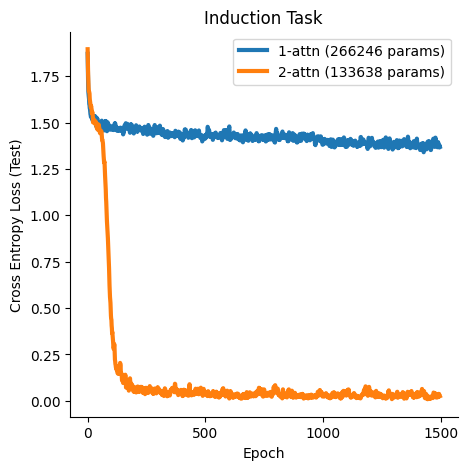

In [405]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(movmean(np.array(simple_train_losses), 3), label=f"1-attn ({num_simple_params} params)", lw=3)
ax.plot(movmean(np.array(complex_test_losses), 3), label=f"2-attn ({num_complex_params} params)", lw=3)
ax.set_ylabel("Cross Entropy Loss (Test)")  
ax.legend()
ax.set_xticks([0, 500, 1000, 1500])
ax.set_title("Induction Task")
ax.set_xlabel("Epoch")
sns.despine()

In [383]:
X, y = dataset.generate_batch(100, type="test")


In [392]:
torch.tril(torch.ones(max_positions, max_positions))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [403]:
max_positions = 10
x = complexModel.embed(X)
x = x + complexModel.position(X)
a_1, a_w =complexModel.attention_layer_1(x, x, x, need_weights=True, attn_mask=torch.tril(torch.ones(max_positions, max_positions)))
x = x + a_1
a_2, a_w2 = complexModel.attention_layer_2(x, x, x, need_weights=True, attn_mask=torch.tril(torch.ones(max_positions, max_positions)))
x = x + a_2

pred = complexModel(X)
y_pred = torch.argmax(pred, dim=1)

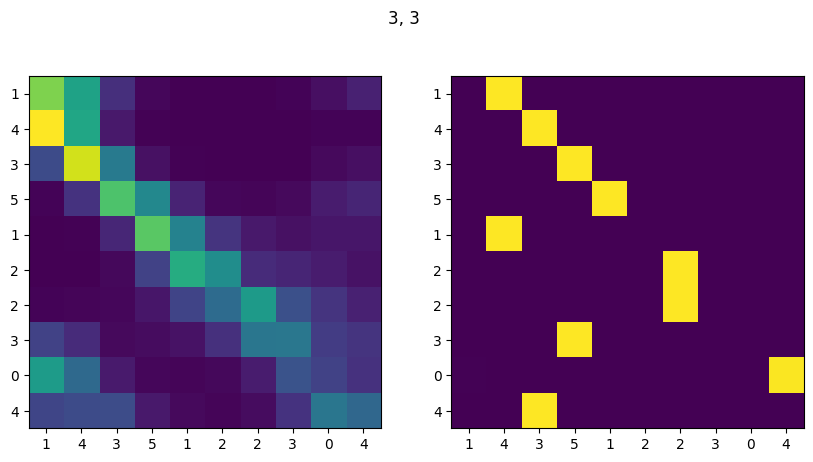

In [404]:
sample += 1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(a_w.detach().numpy()[sample])
ax[1].imshow(a_w2.detach().numpy()[sample])
for i in range(2):
    ax[i].set_xticks(np.arange(10), labels=X[sample].numpy())
    ax[i].set_yticks(np.arange(10), labels=X[sample].numpy())
fig.suptitle(f"{y[sample]}, {y_pred[sample]}")
plt.show()